Analysis Format:

I. Data Preparation    
    1. Clean Data       
    2. Create Variables 
    3. Explore          
    4. Split Train - CV - Test  
II. Statistical Exploration / Unsupervised Learning
    5. Principle Component Analysis (PCA)
    6. Clustering
III. Stats Models + Supervised Learning
    7. Logistic Regression   
    8. Tree-Based Models
        8a. Decision Tree
        8b. Random Forest
        8c. Boosting
        8d. Adding Extra Random Trees
IV. Conclusion with Model Comparion & Prediction Results

In [1]:
%matplotlib inline

In [2]:
#Coding packages
import os
import pandas as pd
import re 
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
#solves 'cannot import name signature' error
import inspect  
import string
from IPython.display import display


#Data Prep
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

#Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score, zero_one_loss
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn import tree
import sklearn as sc
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices

#PCA & Clustering
# from sklearn.datasets import fetch_20newsgroups, load_digits
from sklearn.feature_extraction.text import TfidfVectorizer
# these are new imports for dimensionality reduction
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
# these are new imports for clustering
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.cluster.hierarchy import linkage, dendrogram
import sklearn.cluster as cluster
import time
import seaborn as sns
from ggplot import *





# I. Data Preparation

## 1. Clean Data

In [3]:
df = pd.read_csv("titanic_full.csv")

In [4]:
# https://www.kaggle.com/c/titanic/data
#Rename columns & drop 'body' variable
df = df.rename(columns={'home.dest': 'homeDest', })
df = df.drop('body', 1)

## 2. Create Variables

In [104]:
#Create variables
#Letter of Cabins
#Cabin Letter

# female = 0, Male = 1
df['gender'] = df['sex'].map( {'female': 0, 'male': 1} ).astype(int)

# All missing Embarked -> just make them embark from most common place
if len(df.embarked[ df.embarked.isnull() ]) > 0:
    df.embarked[ df.embarked.isnull() ] = df.embarked.dropna().mode().values

#View
display(df.head())
display(df.shape)
print("NOTE: Categorical Variables are too diverse would have created too sparse of a dataframe if I dummy coded them")

,survived,name,sex,age,sibsp,parch,pclass,ticket,fare,cabin,embarked,boat,homeDest,gender
0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,1,24160,211.3375,B5,S,2,"St Louis, MO",0
1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,1,113781,151.5500,C22 C26,S,11,"Montreal, PQ / Chesterville, ON",1
2,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,1,113781,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON",0
3,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,1,113781,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON",1
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,1,113781,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON",0


(1309, 14)

NOTE: Categorical Variables are too diverse would have created too sparse of a dataframe if I dummy coded them


In [6]:
#Drop NA
#Drop all rows where iloc(0,3,4,5,6) rows have NA
df2 = df[np.isfinite(df.iloc[:,(0,3,4,5,6)])]  #Get surviv
# df.embarked.dropna().mode().values
print(df.shape)
print(df2.shape)

(1309, 14)
(1309, 14)


In [7]:
#Remove Nulls in numeric columns
df2 = df.iloc[:,(0,3,4,5,6,8,13)].dropna()

#Count if nulls exist by column
df2.isnull().sum(axis=0)

survived    0
age         0
sibsp       0
parch       0
pclass      0
fare        0
gender      0
dtype: int64

## 3. Explore

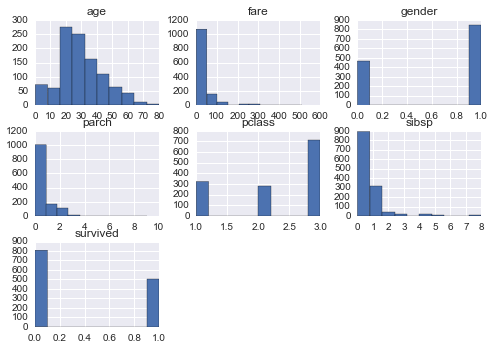

None

C:\Users\jberthet001\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


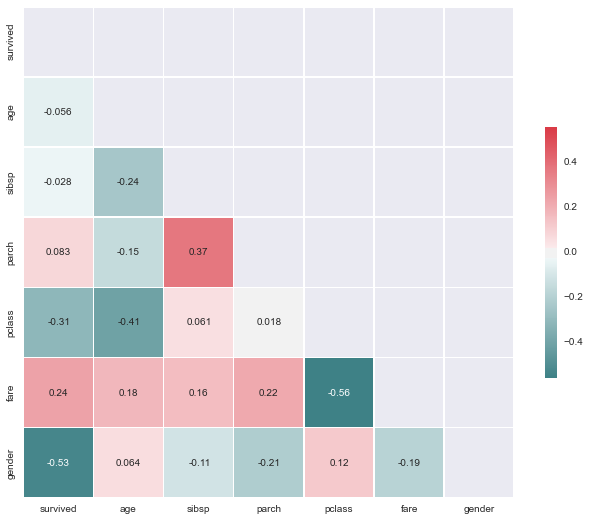

In [8]:
# display(plt.scatter(df['age'], df['fare']))
df.hist()
display(pl.show())

#Plot Correlation Matrix
corr = df.corr()

#Generate mask for upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, annot = True,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.2, cbar_kws={"shrink": .5}, ax=ax)

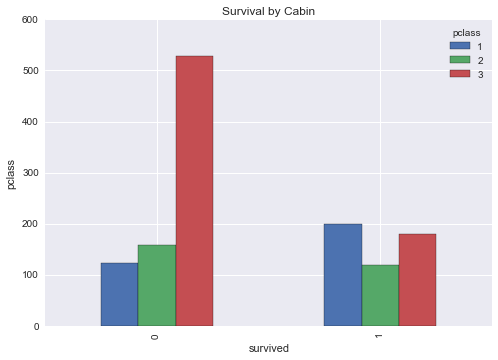

In [9]:
# barplot of survived rating grouped by cabin (True or False)
pd.crosstab(df.survived, df.pclass.astype('category')).plot(kind='bar')
plt.title('Survival by Cabin')
plt.xlabel('survived')
plt.ylabel('pclass')

## 4. Split Train - CV - Test

In [10]:
#Predictors are all numeric variables : age, sibsp, parch, pclass, fare, gender (1 = male, 0 = female)
X = df2.iloc[:,1:].values.reshape(((df2.shape[0]),(df2.shape[1]-1)))
y = df2.iloc[:,0].values.reshape((df2.shape[0],1))

# X2 = df[c('parch', 'fare'].values.ravel
# y2 = df['survived'].values.ravel

display(X)
display(type(y))

array([[  29.    ,    0.    ,    0.    ,    1.    ,  211.3375,    0.    ],
       [   0.9167,    1.    ,    2.    ,    1.    ,  151.55  ,    1.    ],
       [   2.    ,    1.    ,    2.    ,    1.    ,  151.55  ,    0.    ],
       ..., 
       [  26.5   ,    0.    ,    0.    ,    3.    ,    7.225 ,    1.    ],
       [  27.    ,    0.    ,    0.    ,    3.    ,    7.225 ,    1.    ],
       [  29.    ,    0.    ,    0.    ,    3.    ,    7.875 ,    1.    ]])

numpy.ndarray

In [11]:
#Create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 10)

Turn np.ndarray into pd.core.frame.DataFrame' (used in later models & plots)

In [12]:
X_train_df = pd.DataFrame(X_train)
X_train_df.columns = ['age', 'sibsp','parch', 'pclass', 'fare', 'Gender']
print(X_train_df.head())

y_train_df = pd.DataFrame(y_train)
y_train_df.columns = ['survived']
print(y_train_df.head())

X_test_df = pd.DataFrame(X_test)
X_test_df.columns = ['age', 'sibsp','parch', 'pclass', 'fare', 'Gender']
print(X_test_df.head())

y_test_df = pd.DataFrame(y_test)
y_test_df.columns = ['survived']
print(y_test_df.head())

   age  sibsp  parch  pclass     fare  Gender
0   26      0      0       3   7.9250       0
1   39      0      0       2  13.0000       1
2   17      0      0       3   7.8958       1
3   10      5      2       3  46.9000       0
4    1      0      2       3  15.7417       0
   survived
0         1
1         0
2         0
3         0
4         1
   age  sibsp  parch  pclass     fare  Gender
0   25      0      0       3   7.2500       1
1    8      1      1       2  26.0000       0
2   31      0      0       3   7.7500       1
3   48      0      0       3   7.8542       1
4   35      0      0       3   7.7500       0
   survived
0         0
1         1
2         0
3         0
4         0


In [13]:
# print (X_test)
# print (y_train[1:5])
# print (y_test[1:5])
# print (X_train.shape)
# print (X_test.shabpe)
# print (y_train.shape)
# print (y_test.shape)

# print (X_test_df)
# print (y_train_df[1:5])
# print (y_test_df[1:5])
# print (X_train_df.shape)
# print (X_test_df.shape)
# print (y_train_df.shape)
# print (y_test_df.shape)

# II. Statistical Exploration / Unsupervised Learning


## 5.  Principle Component Analysis (PCA)

Load Packages for PCA & Kmeans

In [106]:
#Use nuermic only dataframe
print(X_train_df.head())
print(X.shape)

   age  sibsp  parch  pclass     fare  Gender
0   26      0      0       3   7.9250       0
1   39      0      0       2  13.0000       1
2   17      0      0       3   7.8958       1
3   10      5      2       3  46.9000       0
4    1      0      2       3  15.7417       0
(1045, 6)


Run a simple PCA using scikit-learn class. If I don't specify n_components or set it to None, it will use the maximum number of principal components:

In [108]:
pca = PCA(n_components = None)
pca.fit(X_train_df)

PCA(copy=True, n_components=None, whiten=False)

In [109]:
pca.components_

array([[  4.11753890e-02,   2.74872303e-03,   3.23396761e-03,
         -8.64143116e-03,   9.99104158e-01,  -1.66746989e-03],
       [  9.98720309e-01,  -1.91479635e-02,  -1.02227790e-02,
         -1.92819300e-02,  -4.12342087e-02,   3.81343342e-03],
       [ -2.30725262e-02,  -7.80684815e-01,  -6.13089026e-01,
         -8.86365706e-02,   4.44842189e-03,   7.90221166e-02],
       [  8.54311643e-04,  -6.18085269e-01,   7.31787432e-01,
          2.35238090e-01,   1.05633567e-03,  -1.64678323e-01],
       [ -1.71296716e-02,  -6.86679206e-02,   1.95758220e-01,
         -9.50548371e-01,  -8.34467058e-03,  -2.30343595e-01],
       [ -5.98624724e-03,  -5.84152176e-02,   2.23992759e-01,
         -1.81157188e-01,  -2.89274336e-04,   9.55803882e-01]])

look at explained variance of each principal component...

In [110]:
pca.explained_variance_ratio_

array([  9.38468891e-01,   6.09045931e-02,   2.84855728e-04,
         1.49085528e-04,   1.29724759e-04,   6.28503850e-05])

...and plot it

C:\Users\jberthet001\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


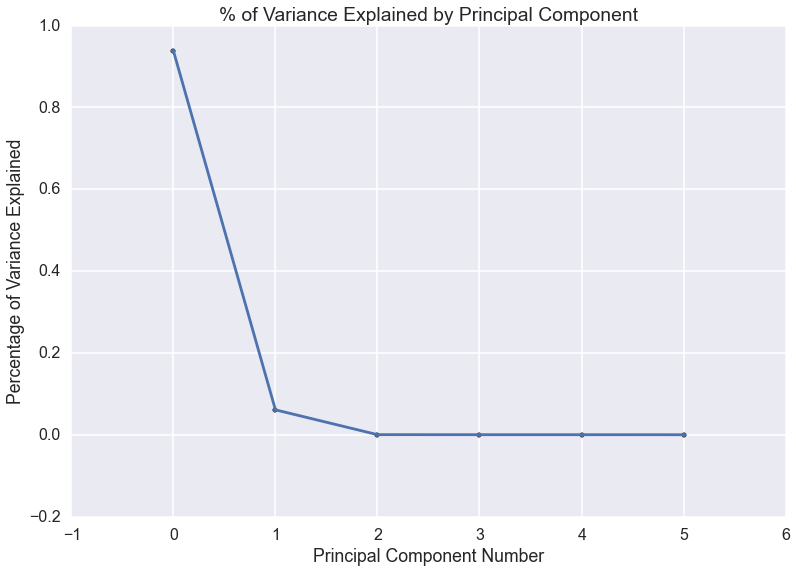

In [111]:
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.scatter(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.xlabel("Principal Component Number")
plt.ylabel("Percentage of Variance Explained")
plt.title('% of Variance Explained by Principal Component')
plt.show()

C:\Users\jberthet001\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


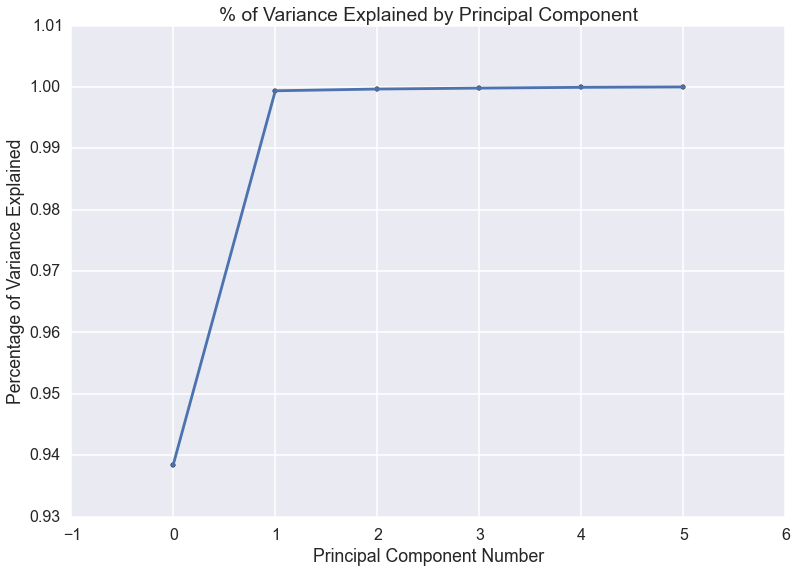

In [112]:
#Show Cumulative Sum of Principal Components
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(pca.explained_variance_ratio_)), cumsum)
plt.scatter(range(len(pca.explained_variance_ratio_)), cumsum)
plt.xlabel("Principal Component Number")
plt.ylabel("Percentage of Variance Explained")
plt.title('% of Variance Explained by Principal Component')
plt.show()

CONCLUSION: If we're looking for an "elbow", it looks like 1 principal component would be enough to explain most of the variance in the data.  To actually get each row transformed into the principal component space, we can call `transform` on an already fit `PCA` object, or we can do both at once with `fit_transform`:

In [113]:
pca2 = PCA(n_components = 2)
X_trans = pca2.fit_transform(X_train_df)
print(X_trans.shape)  #PC score vectors have length = 731
print(X_trans)

(731, 2)
[[-28.72603632  -2.70603501]
 [-23.1133287   10.09116076]
 [-29.12745614 -11.68950031]
 ..., 
 [-30.35875168  -7.65603915]
 [ -2.98774758 -20.83366656]
 [-26.2671466   -5.80442662]]


In [114]:
pd.DataFrame(pca2.components_, index = ['PC1','PC2'], columns = ['age', 'sibsp', 'parch', 'pclass', 'fare', 'gender'] )

,age,sibsp,parch,pclass,fare,gender
PC1,0.041175,0.002749,0.003234,-0.008641,0.999104,-0.001667
PC2,0.998720,-0.019148,-0.010223,-0.019282,-0.041234,0.003813


Now define a function for plotting

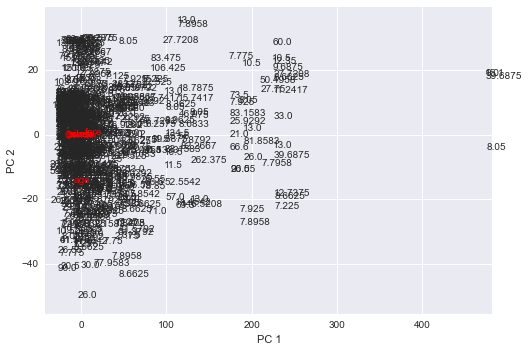

In [22]:
def plot_PCA(pca, X_train, print_row_labels, row_labels, col_labels, biplot=False, y_scale=(None, None), font_size=None):
    # transform our data to PCA space
    X_trans = pca.fit_transform(X)

    # handle the scaling of the plot
    xmin, xmax = min(X_trans[:, 0]), max(X_trans[:, 0])
    if y_scale == (None, None):
        ymin, ymax = min(X_trans[:, 1]), max(X_trans[:, 1])
        xpad, ypad = 5, 5
    else:
        ymin, ymax = y_scale
        xpad, ypad = 5, 1
        
    plt.xlim(xmin - xpad, xmax + xpad)
    plt.ylim(ymin - ypad, ymax + ypad)

    # plot words instead of points
    if print_row_labels:
        for x, y, label in zip(X_trans[:, 0], X_trans[:, 1], row_labels):
            if font_size is None:
                plt.text(x, y, label)
            else:
                plt.text(x, y, label, size=font_size)
    else:
        for x, y in zip(X_trans[:, 0], X_trans[:, 1]):
            plt.scatter(x, y)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    # if we want a biplot, get the loading and plot
    # axes with labels
    if biplot:
        eigenvectors = pca.components_.transpose()
        for i, col in enumerate(col_labels):
            x, y = 10*eigenvectors[i][0], 10*eigenvectors[i][1]
            plt.arrow(0, 0, x, y, color='r', width=0.002, head_width=0.05)
            plt.text(x* 1.4, y * 1.4, col, color='r', ha='center', va='center')
    
    plt.show()
    
pca = PCA(n_components=2)
#fare 
plot_PCA(pca, X_train_df, True, X_train_df.fare, X_train_df.columns, biplot=True)

Combination of all the numerical variables are pushed to 1 Principal component, which is very strong. Other than 'age', no single variable is dominated by a strong trend or presence of consistent results. age and fare are the variables with the most influence.

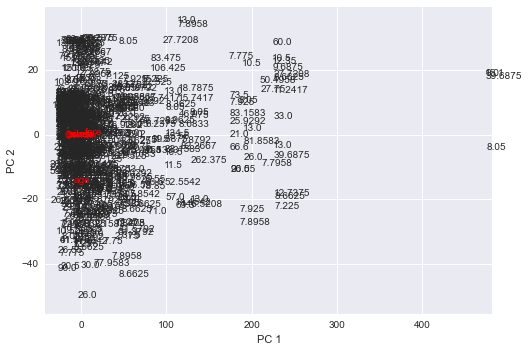

In [23]:
#Center & Scale to unit variance
pca = PCA(n_components=4)
X_scaled = scale(X_train_df, with_mean=True, with_std=True)  #
plot_PCA(pca, X_scaled, True, X_train_df.fare, X_train_df.columns, biplot=True)

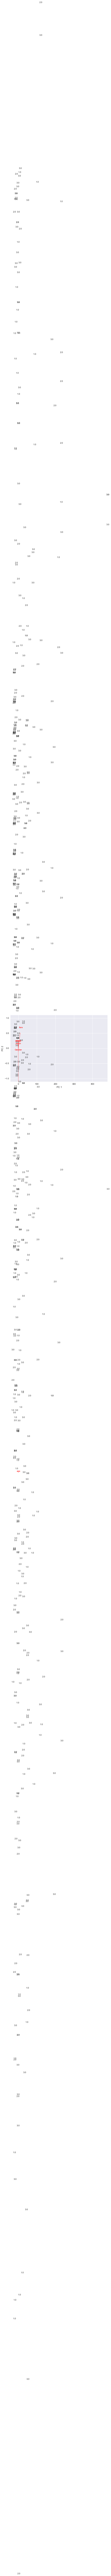

In [24]:
pca = PCA(n_components=2)
X_scaled = scale(X_train_df, with_mean=True, with_std=True)
plot_PCA(pca, X_scaled, True, X_train_df.pclass, X_train_df.columns, biplot=True, y_scale=(-0.1, .1))

It seems that the age largely drives the first principal component and fare mostly drives the 2nd principal component.

## t-SNE (t-Distributed Stochastic Neighbor Embedding)

Implement the t-Distributed Stochastic Neighbor Embedding (t-SNE) dimensionality reduction that's well suited for high-dimensional datasets (http://lvdmaaten.github.io/tsne/)

PC1 = red/0, PC2 = blue/1


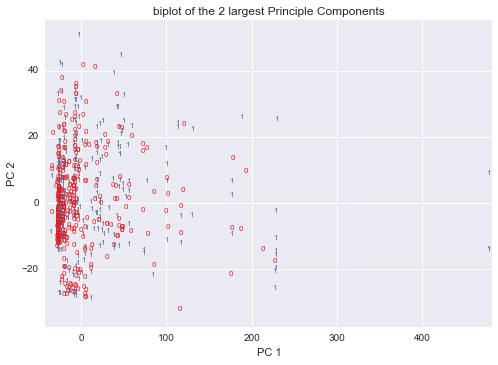

In [25]:
#Plot the first 2 principal components, colored & labeled by true digit:

xmin, xmax = min(X_trans[:, 0]), max(X_trans[:, 0])
ymin, ymax = min(X_trans[:, 1]), max(X_trans[:, 1])
xpad, ypad = 5, 5
plt.xlim(xmin - xpad, xmax + xpad)
plt.ylim(ymin - ypad, ymax + ypad)

for x, y, label in zip(X_trans[:, 0], X_trans[:, 1], df.survived):
    plt.text(x, y, label, size=8, color=plt.cm.Set1(label/10.))

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title('biplot of the 2 largest Principle Components')
print("PC1 = red/0, PC2 = blue/1")
plt.show()

There's a scikit-learn class for running t-SNE.There's a scikit-learn class for running t-SNE.

In [26]:
tsne = TSNE(n_components=2, verbose=True)
X_trans = tsne.fit_transform(df2)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1045
[t-SNE] Computed conditional probabilities for sample 1045 / 1045
[t-SNE] Mean sigma: 1.737570
[t-SNE] Error after 100 iterations with early exaggeration: 0.598002
[t-SNE] Error after 125 iterations: 0.546893


Make a plot of the the first 2 Principal Components and color / label by the true digit.

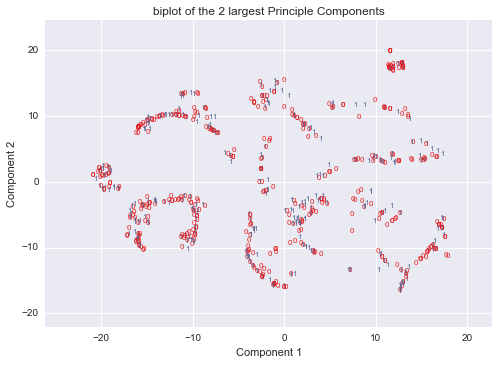

In [27]:
xmin, xmax = min(X_trans[:, 0]), max(X_trans[:, 0])
ymin, ymax = min(X_trans[:, 1]), max(X_trans[:, 1])
xpad, ypad = 5, 5
plt.xlim(xmin - xpad, xmax + xpad)
plt.ylim(ymin - ypad, ymax + ypad)

#for x, y, label in zip(digits_trans[labels==6, 0], digits_trans[labels==6, 1], labels[labels==6]):
for x, y, label in zip(X_trans[:, 0], X_trans[:, 1], y_train_df.survived):
    plt.text(x, y, label, size=8, color=plt.cm.Set1(label/10.))

plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.title('biplot of the 2 largest Principle Components')

plt.show()

CONCLUSION : Fascinatingly, the 1st (1s/red) and 2nd Principle Components (0s/blue) follow each other. This is to be expected as these two principal componenets capture most of the variance in the model. Note, the 1st Principal Component tends to cluster in a smaller area with itself that the 2nd Principal Component is unable to capture as well.

## 6. Clustering

### Hierarchical

Now I use some functions from scipy to run hierarchical clustering. 

'Linkage' calculates the distances and linkages. 

'Dendogram' displays the actual trees

In [28]:
clusters_single = linkage(scale(X_train_df), method = 'single', metric = 'euclidean') #methods = single, complete, average, and ward

Single linkage tends to produce really unbalanced trees.  The dendograms shows that there's clusters of data.

C:\Users\jberthet001\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


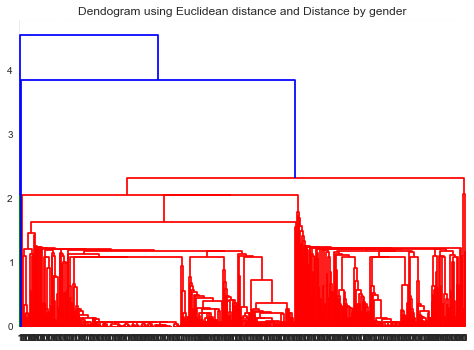

In [29]:
dendr = dendrogram(clusters_single, orientation='top', labels = list(df.gender))
plt.title('Dendogram using Euclidean distance and Distance by gender')

C:\Users\jberthet001\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


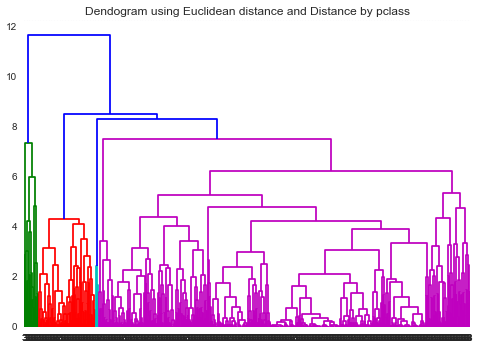

In [30]:
clusters_single = linkage(scale(X_train_df), method = 'complete', metric = 'euclidean') #methods = single, complete, average, and ward
dendr = dendrogram(clusters_single, orientation='top', labels = list(df.pclass))
plt.title('Dendogram using Euclidean distance and Distance by pclass')

Link provides great way to just look at your data for exploratory analysis. There's a lot of clustering algorithms, but we'll use HDBSCAN - a sort of desnity based algorithm, which clusters for dense regions. Unlike kmeans, it doesn't try to cluster every group, but extracts dense clusters and leaves sparse data as 'noise'. It's

http://nbviewer.jupyter.org/github/lmcinnes/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb 

# III. Stats Models + Supervised Learning

## 7. Logistic Regression

Construct and fit the scikit-learn classifier, 
which should follow the workflow: construct, fit, predict  

In [35]:
#Fit Regression Model
logit = LogisticRegression(penalty = "l1", C=1e5)  #make logistic regression class
logit.fit(X_train, y_train.ravel())  #Fit the training data into the 'logit' function.
#From now on, logit() will be the model logistic regression model created from training data.

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [36]:
#Get Predictions from the training data
train_preds = logit.predict(X_train)  #Get predictions using just training data
print(len(train_preds))
print(train_preds[1:20])

#Get predicted probabilities, so get an array for each passenger.
#This code is doing a 1 vs. rest probability
train_probs = logit.predict_proba(X_train)[:,1] #prob. survived = 1
print(train_probs[1:50])

#But since we want to predict, we need to use the model we created
#from the training data, and predict new probability values  based on X_test data.
#logit.predict_proba gives me the mean accuracy on the given test data & labels
test_preds = logit.predict(X_test)
test_probs = logit.predict_proba(X_test)[:,1]

731
[0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0]
[ 0.2073972   0.15114742  0.37056606  0.80198212  0.09539307  0.62635147
  0.21174304  0.34476279  0.94548873  0.24951871  0.27758684  0.44458225
  0.23125262  0.28458033  0.37698158  0.13008     0.85685128  0.61729569
  0.27074632  0.44240625  0.57528871  0.28411826  0.13007942  0.5581161
  0.80009701  0.64971471  0.87458174  0.08189973  0.84460578  0.48026112
  0.13007942  0.5126055   0.05878089  0.83152153  0.23130864  0.10482472
  0.94760197  0.42794398  0.14240159  0.22005913  0.31392353  0.11507181
  0.87841402  0.55605931  0.62536061  0.13408277  0.23600348  0.87314747
  0.55760468]


# Evaluating the Classifier Performance

scikit learn confusion matrix fn takes the true and predicted labels.
We can also use the crosstab function in pandas, which has the advantage that it's clear which are rows and which are columns:

Training Confusion Matrix

In [117]:
#Good at predicting species 1, but not so much for species 2 and 3.
#Compute a simple cross-tabulation of two (or more) factors. By default
# computes a frequency table of the factors
#confusion_matrix(y_true = y_train, y_pred = training_preds))  #same as fn below
print ("Train Confusion Matrix")
pd.crosstab(index=np.ravel(y_train), columns=np.ravel(train_preds), rownames=['Survived'], colnames=['Predicted'])

Train Confusion Matrix


Predicted,0,1
Survived,,
0,357,72
1,93,209


In [116]:
print ("Test Confusion Matrix")
pd.crosstab(index=np.ravel(y_test), columns=np.ravel(test_preds), rownames=['Survived'], colnames=['Predicted'])

Test Confusion Matrix


Predicted,0,1
Survived,,
0,165,24
1,36,89


In [39]:
#see percentage of how many I'm getting right. So, ~22.6% we're getting wrong with Log. Regression.
print ('Percent correct on Training Data : {}'.format(accuracy_score(y_true=y_train, y_pred=train_preds)*100) )
print ('Percent correct on Test Data : {}'.format(accuracy_score(y_true=y_test, y_pred=test_preds)*100) )

Percent correct on Training Data : 77.4281805745554
Percent correct on Test Data : 80.89171974522293



Below: 

The f1-score gives you the harmonic mean of precision and recall. 

The scores corresponding to every class will tell you the accuracy of the classifier in classifying the data points in that particular class compared to all other classes.

The support is the number of samples of the true response that lie in that class.

In [118]:
#This gives out diff. metrics
print (classification_report(y_true = y_train,
                             y_pred = train_preds,
                             labels =[0,1],
                             target_names = ['class 0', 'class 1']))
print ("precision (aka specificity = True Positive Rate) positive predictive value) is the fraction of retrieved instances that are relevant")
print ("recall (aka sensitivity) is the fraction of relevant instances that are retrieved.")

             precision    recall  f1-score   support

    class 0       0.79      0.83      0.81       429
    class 1       0.74      0.69      0.72       302

avg / total       0.77      0.77      0.77       731

precision (also called positive predictive value) is the fraction of retrieved instances that are relevant
recall (also known as sensitivity) is the fraction of relevant instances that are retrieved.


Now, make a ROC curve

In [41]:
# The roc_curve function returns three arrays. One for the false positive rate, one for the true positive rate, and one for the probability thresholds that correspond to each point:
#Takes true and predicted values and returns fpr, tpr and thresholds
#here, you can return a list of 3 things, and you assign those three things into 3 separate variables
fpr, tpr, thresholds = roc_curve(y_true = y_test,
                                 y_score = test_probs)

A ROC Curve is a graphical plot that illustrates the performance of a binary classifier system as its discrimnation threshold varies.

The ROC Curve for the logistic regression classifier traces 2 types of error as the data varies by threshold, provided by different values of the predictors. Actual threshold is not shown, 

The True Positive Rate is the sensitivity : the fraction of those who lived that are CORRECTLY identified as lived ('survived' = 1). This is aka 'sensitivity'

The False Postive Rate is 1-specificity : the fraction of those who died ('survived'=0) that are INCORRECTLY identified as lived. This is aka '1-specificity'. (NOTE: specificity is the fraction of those that died that are CORRECTLY identified as died ('survived'=0).)

The ROC curve looks at the True Positive Rate and False Positive Rate for the same threshold value. 

The ideal ROC curve hugs the top left corner, indivicating a high true positive rate and a low false positive rate. The dotted line represents the "no information" classifier, or the line that is assumed result of guessing 50/50 that someone survived or not. More deeply, the dotted line is what I would expect if the predictors are not associated with probability of living or dieing.

Threshold shows that our probability values go from near 1 to near 0 over all values for fpr and tpr
The plot shows that when Threshold is near 0, then the classifier takes
takes in nearly all classifications, thus making the FPR near 1.
But when the Threshold is very high and it does not accept errors,
then misclassification is nearly 0 and so is the FPR.


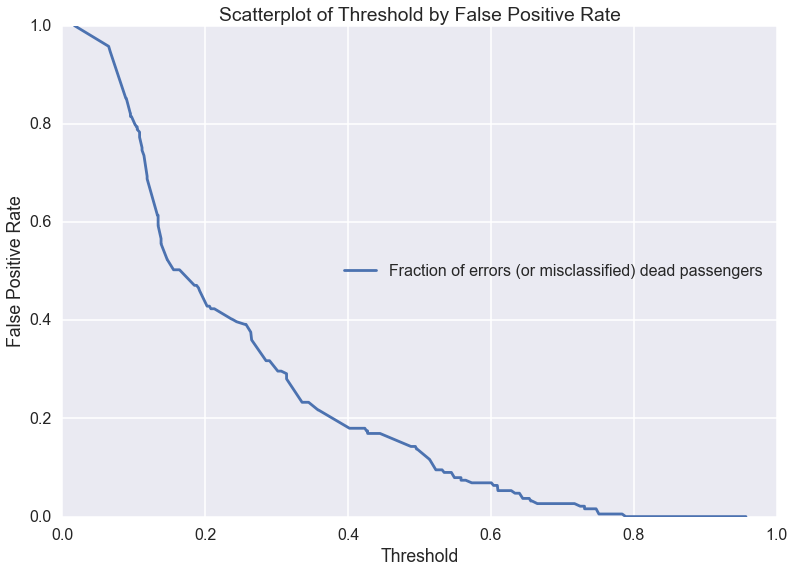

In [121]:
pl.plot( thresholds, fpr)
pl.xlabel('Threshold')
pl.ylabel('False Positive Rate')
pl.legend(["Fraction of errors (or misclassified) dead passengers"], loc = 7)
pl.title('Scatterplot of Threshold by False Positive Rate')
print ("""Threshold shows that our probability values go from near 1 to near 0 over all values for fpr and tpr
The plot shows that when Threshold is near 0, then the classifier takes
takes in nearly all classifications, thus making the FPR near 1.
But when the Threshold is very high and it does not accept errors,
then misclassification is nearly 0 and so is the FPR.""")

AUC is 0.8398014788743267


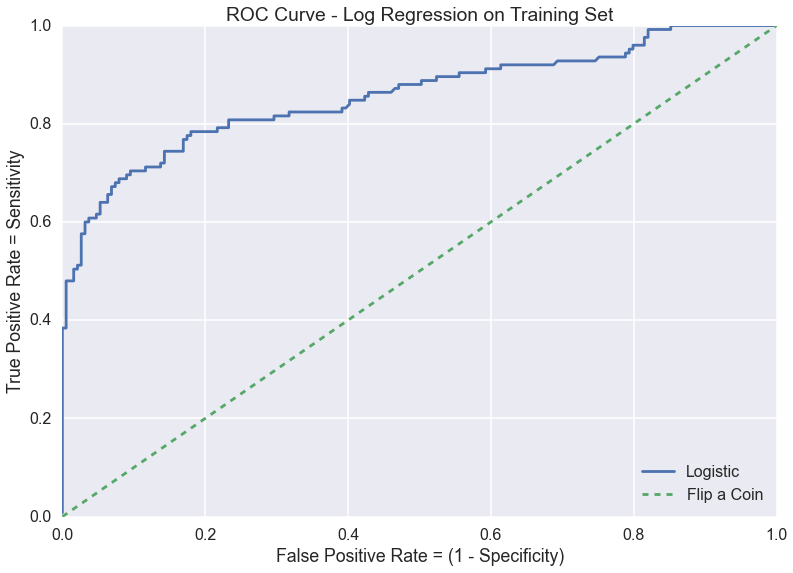

In [122]:
# we want to draw the random baseline ROC line too
fpr_rand = tpr_rand = np.linspace(0, 1, 10)

print('AUC is {}'.format(roc_auc_score(y_train, train_probs)))   #get AUC curve w/ simple fn here.
plt.plot(fpr, tpr)     #make auc curve
plt.plot(fpr_rand, tpr_rand, linestyle='--')   #make random line
pl.legend(["Logistic", "Flip a Coin"], loc = 4)
plt.xlabel('False Positive Rate = (1 - Specificity)')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC Curve - Log Regression on Training Set')
plt.show()

Now, build a ROC curve on the Test Data

In [43]:
#roc_curve() returns fpr, tpr, & thresholds
#Increasing FPR, Increasing TPR, Decreasing thresholds 
fpr, tpr, thresholds = roc_curve(y_true=y_test,  
                                 y_score=test_probs) #target scores (ie - probability estimates) 

AUC is 0.8573121693121692


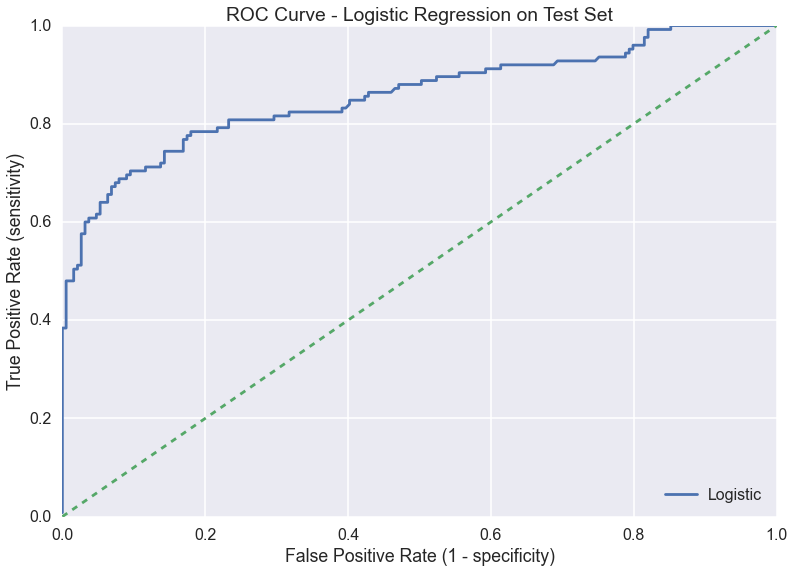

In [123]:
# draw the random baseline ROC line too
fpr_rand = tpr_rand = np.linspace(0, 1, 10)

print('AUC is {}'.format(roc_auc_score(y_test, test_probs)))   #get AUC curve w/ simple fn here.
plt.plot(fpr, tpr)
pl.legend(["Logistic", "Flip a Coin"], loc = 4)
plt.plot(fpr_rand, tpr_rand, linestyle='--')
plt.title('ROC Curve - Logistic Regression on Test Set')
plt.xlabel('False Positive Rate (1 - specificity)')
plt.ylabel('True Positive Rate (sensitivity)')
plt.show()

## Cross Validation of Logistic Regression

NOTE: If re-run the train/test split will show variability in this estimate.

We can use the test set (which, in this case, should really be called a validation set) to choose the best value of the tuneable parameter 'C' of the logistic regression, which is the inverse of λ , the regularization strength. So depending on a range of 'penalties' I apply to the logistic regression that weakens larger coefficients to reduce overfitting.

Iterating over 'C' values can provide better future prediction model.

In [46]:
# create equally space values beteen 10^-10 and 10^10
c_vals = np.logspace(-10, 10, 20)

aucs = []
for c_val in c_vals:
    logit = LogisticRegression(C=c_val)      # 'C' = inverse of regularization strength. The higher 'C' the lower the penalization
    logit.fit(X_train, y_train.ravel())

    test_probs_cv = logit.predict_proba(X_test)[:, 1]
    aucs.append(roc_auc_score(y_test, test_probs_cv))
    
#Notice that AUC score from before matches the converged AUC scores at the end of this list.
aucs

[0.69157671957671951,
 0.69066666666666676,
 0.69066666666666665,
 0.69005291005291003,
 0.68810582010582011,
 0.68002116402116408,
 0.69157671957671973,
 0.7657354497354496,
 0.82736507936507919,
 0.85174603174603181,
 0.85703703703703715,
 0.85716402116402113,
 0.85733333333333339,
 0.85729100529100521,
 0.85729100529100521,
 0.85729100529100521,
 0.85729100529100521,
 0.85729100529100521,
 0.85729100529100521,
 0.85729100529100521]

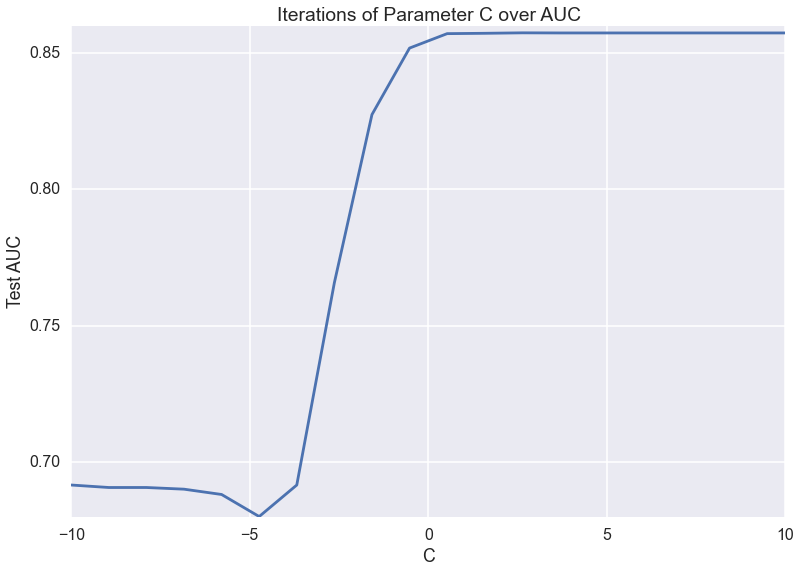

In [47]:
plt.plot(np.log10(c_vals), aucs)
plt.xlabel("C")
plt.ylabel("Test AUC")
plt.title('Iterations of Parameter C over AUC')

plt.show()

#NOTE: Where tuning parameter 'C' is roughly above -2, AUC value maximizes & plateaus.

Instead of using a train/test split, I can use cross-validation in scikit-learn to choose the tuneable parameters of a model.

First, I make a dictionary, where the key is the name of the parameter we want to tune (it has to match the name of the parameter in the model), and the values are the values we want to try:

In [48]:
param_grid = {"C" : np.logspace(2,8,50)}   # start, stop, # of samples to generate
param_grid

{'C': array([  1.00000000e+02,   1.32571137e+02,   1.75751062e+02,
          2.32995181e+02,   3.08884360e+02,   4.09491506e+02,
          5.42867544e+02,   7.19685673e+02,   9.54095476e+02,
          1.26485522e+03,   1.67683294e+03,   2.22299648e+03,
          2.94705170e+03,   3.90693994e+03,   5.17947468e+03,
          6.86648845e+03,   9.10298178e+03,   1.20679264e+04,
          1.59985872e+04,   2.12095089e+04,   2.81176870e+04,
          3.72759372e+04,   4.94171336e+04,   6.55128557e+04,
          8.68511374e+04,   1.15139540e+05,   1.52641797e+05,
          2.02358965e+05,   2.68269580e+05,   3.55648031e+05,
          4.71486636e+05,   6.25055193e+05,   8.28642773e+05,
          1.09854114e+06,   1.45634848e+06,   1.93069773e+06,
          2.55954792e+06,   3.39322177e+06,   4.49843267e+06,
          5.96362332e+06,   7.90604321e+06,   1.04811313e+07,
          1.38949549e+07,   1.84206997e+07,   2.44205309e+07,
          3.23745754e+07,   4.29193426e+07,   5.68986603e+07,
   

Then, we pass in the model we want to fit and the grid. The option 'n_jobs' allows to split the cross-validation over multiple cores of your computer, and refit tells it to fit the best performing model on the full dataset once it's done.

The parameters selected are those that maximize the score of the left out data, unless an explicit score is passed in which case it is used instead.

In [49]:
cv = GridSearchCV(logit, param_grid, cv=10,
                  n_jobs=1, refit=True, verbose=True)

In [50]:
cv.fit(X_train, y_train.ravel())

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    1.5s finished


Fitting 10 folds for each of 50 candidates, totalling 500 fits


GridSearchCV(cv=10, error_score='raise',
       estimator=LogisticRegression(C=10000000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e+02,   1.32571e+02,   1.75751e+02,   2.32995e+02,
         3.08884e+02,   4.09492e+02,   5.42868e+02,   7.19686e+02,
         9.54095e+02,   1.26486e+03,   1.67683e+03,   2.22300e+03,
         2.94705e+03,   3.90694e+03,   5.17947e+03,   6.86649e+03,
         9.1029...    2.44205e+07,   3.23746e+07,   4.29193e+07,   5.68987e+07,
         7.54312e+07,   1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=True)

In [51]:
#Estimator that was chosen by the search. This estimator gave the highest
#score (or smallest loss) on the test data. That happens because I set 
# refit=True, baby!
cv.best_estimator_  

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [52]:
# This is the parameter setting that gave me the best results in the test data
cv.best_params_  #Best C value is 100

{'C': 100.0}

Let's see what value of $\lambda$ corresponds to the best C:

In [53]:
np.log10(1.0/cv.best_params_['C'])

-2.0

In [54]:
cv.best_score_   #Score of best_estimator on test data

0.77154582763337898

AUC for Cross Validated Logistic Regression 0.8561904761904762
AUC for non-Cross Validated Logistic Regression 0.8573121693121692
Interestingly, cross-validating with the training set seemed to overfit the model slightly compared to performing a normal train/test Log Regression Model


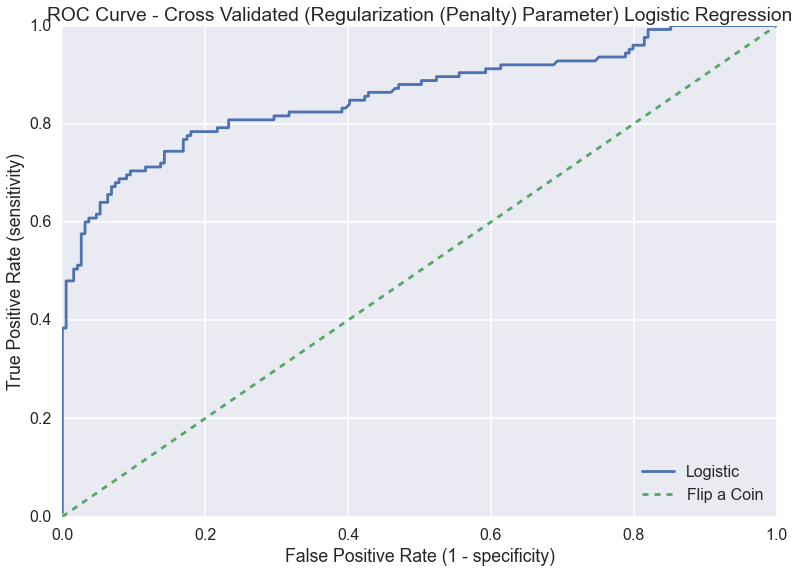

In [148]:
logit_cv = LogisticRegression(C= cv.best_score_)  
logit_cv.fit(X_train, y_train.ravel())

test_probs_cv = logit_cv.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, test_probs_cv)
#Notice 0.85 is the same score as original logistic regression. So original fit did well on test data.

# draw the random baseline ROC line too
fpr_rand = tpr_rand = np.linspace(0, 1, 10)

print('AUC for Cross Validated Logistic Regression {}'.format(roc_auc_score(y_test, test_probs_cv)))   #get AUC curve w/ simple fn here.
print('AUC for non-Cross Validated Logistic Regression {}'.format(roc_auc_score(y_test, test_probs)))   #get AUC curve w/ simple fn here.
print('Interestingly, cross-validating with the training set seemed to overfit the model slightly compared to performing a normal train/test Log Regression Model')
plt.plot(fpr, tpr)
plt.plot(fpr_rand, tpr_rand, linestyle='--')

plt.title('ROC Curve - Cross Validated (Regularization (Penalty) Parameter) Logistic Regression ')
plt.xlabel('False Positive Rate (1 - specificity)')
plt.ylabel('True Positive Rate (sensitivity)')
pl.legend(["Logistic", "Flip a Coin"], loc = 4)
plt.show()

# 8. Tree-Based Models

# 8a. Decision Tree

Supervised Machine Learning is a formalized method for finding useful rules of thumb

Next, we'll train a scikit-learn classification decision tree using the "gini" splitting criterion.
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
We could also have selected the "entropy" criterion. Here's the documentation for the scikit-learn regression decision tree, which splits based on MSE.
http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

In [56]:
#Fit training predictors to training response variable
dt = tree.DecisionTreeClassifier(criterion = "gini", min_samples_split = 10)  #gini or entropy
dt.fit(X_train, y_train)

#Predict probabilities of dead by each predictor value within the test set
dt_test_probs = dt.predict_proba(X_test, 'linear')[:,1]    #other kernels : {‘linear’, ‘rbf’, ‘poly’, ‘sigmoid’, ‘precomputed’}   
print(dt_test_probs)

dt_test_pred = dt.predict(X_test)
print(dt_test_pred[1:50])

[ 0.          1.          0.          0.          0.          0.          1.
  0.          0.          0.          0.66666667  0.25        1.          1.
  0.          1.          0.          0.          0.          0.          0.
  0.66666667  0.25        0.          0.          0.          1.          1.
  0.42857143  0.          0.5         1.          0.          0.          0.
  0.71428571  0.          0.          0.          0.          0.33333333
  0.22222222  0.125       0.375       0.          1.          0.          0.375
  0.          0.          0.4         1.          0.          0.4         0.
  1.          1.          1.          0.77777778  1.          1.          1.
  0.          0.71428571  1.          0.          1.          0.83333333
  1.          0.25        0.          0.2         0.          1.          1.
  0.6         0.          0.          0.22222222  0.          0.
  0.83333333  0.          1.          0.11111111  0.          1.          0.
  0.33333333  1.

Just Looking at Test Results

In [152]:
#see percentage of how many I'm getting right. So, ~22.6% we're getting wrong with Log. Regression.
print ('Percent correct on Test Data : {}'.format(accuracy_score(y_true=y_test, y_pred=dt_test_pred)*100) )
pd.crosstab(index=np.ravel(y_test), columns=np.ravel(dt_test_pred), rownames=['Survived'], colnames=['Predicted'])

Percent correct on Test Data : 79.29936305732484


Predicted,0,1
Survived,,
0,157,32
1,33,92


There's many ways to conrol a tree structure. Usually I just select 1
1. max_depth : the # of layers deep to grow the tree (decision tree & random forest go as deep as possible by default, but gradient boosting goes 3 deep)
2. min_samples_split : stops splitting if there are this many values left in a node. Default is 2 so it always to the end.
3. min_samples_leaf : doesn't consider something a leaf node if it has more than this many values. Default is 1
4. max_leaf_nodes : max # of final leaf nodes I want. Default is None, so we get as many leaf nodes as we can get

0.842793650794


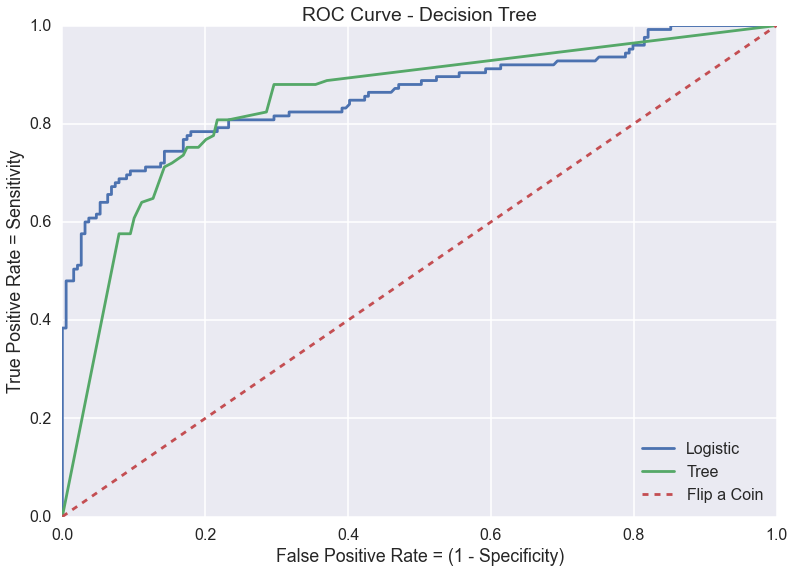

In [59]:
#roc curve for binary classification task
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_true = y_test, y_score = dt_test_probs)

#Draw random baseline ROC line
fpr_rand = tpr_rand = np.linspace(0,1,10)

#Plot decision tree
plt.plot(fpr, tpr)
plt.plot(fpr_dt, tpr_dt)
plt.plot(fpr_rand, tpr_rand, linestyle = '--')


print(roc_auc_score(y_test, dt_test_probs))

plt.xlabel('False Positive Rate = (1 - Specificity)')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC Curve - Decision Tree ')
pl.legend(["Logistic", "Tree", "Flip a Coin"], loc = 4)
plt.show()

Unfortunately, scikit does not prune trees like R does.

## 8b. Random Forest

n_estimators : controls for how many different trees I want to fit, ech one on a bootstrap sampled version of the df2
max_features : controls how many of the different predictors I want to consider splitting at each node
n_jobs : split training up over multiple cores to make it go faster
oob_score : tells rf to save the out-of-bag scores for each sample




logistic regresiion 0.855936507937
Decision Tree 0.842793650794
Random Forest 0.832825396825


C:\Users\jberthet001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


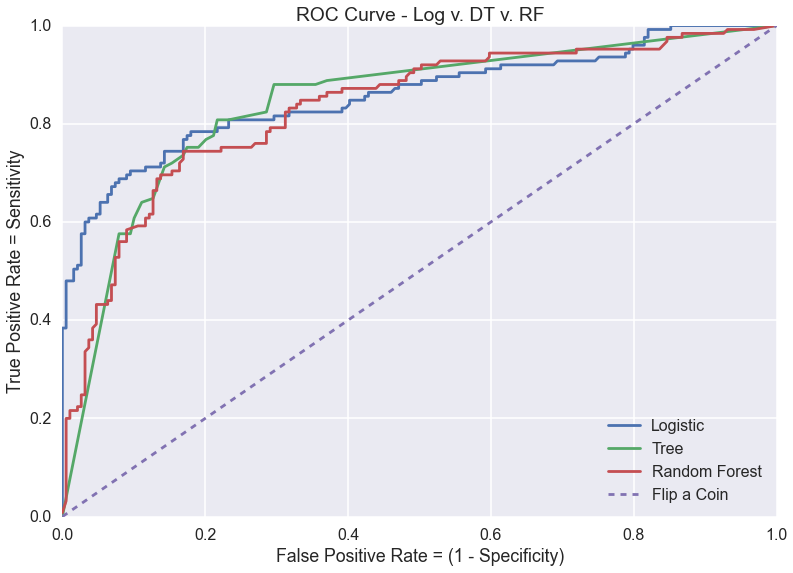

In [60]:
rf = RandomForestClassifier(n_estimators = 500, criterion = 'gini',
                            max_features = 'sqrt', oob_score = True,
                            n_jobs = 2, verbose = 0)

rf.fit(X_train, y_train)

rf_test_preds = rf.predict_proba(X_test)[:,1]
rf_test_preds

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, rf_test_preds)

print ("logistic regresiion %s" % (roc_auc_score(y_test, test_probs_cv)))# print(roc_auc_score(y_bin, bin_preds))             #lo
print("Decision Tree %s" % (roc_auc_score(y_test, dt_test_probs)))
print("Random Forest %s" % (roc_auc_score(y_test, rf_test_preds)))

plt.plot(fpr, tpr)         #logistic Regression
plt.plot(fpr_dt, tpr_dt)   #decision tree
plt.plot(fpr_rf, tpr_rf)   #random forest
plt.plot(fpr_rand, tpr_rand, linestyle = '--')
plt.xlabel('False Positive Rate = (1 - Specificity)')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC Curve - Log v. DT v. RF')
pl.legend(["Logistic", "Tree", "Random Forest", "Flip a Coin"], loc = 4)
plt.show()

In [61]:
rf.predict_proba(X_test)[1:20]

array([[ 0.081     ,  0.919     ],
       [ 0.876     ,  0.124     ],
       [ 0.878     ,  0.122     ],
       [ 0.89033333,  0.10966667],
       [ 0.90986667,  0.09013333],
       [ 0.35196667,  0.64803333],
       [ 0.922     ,  0.078     ],
       [ 0.91566667,  0.08433333],
       [ 1.        ,  0.        ],
       [ 0.21733333,  0.78266667],
       [ 0.634     ,  0.366     ],
       [ 0.014     ,  0.986     ],
       [ 0.384     ,  0.616     ],
       [ 0.874     ,  0.126     ],
       [ 0.008     ,  0.992     ],
       [ 0.926     ,  0.074     ],
       [ 0.922     ,  0.078     ],
       [ 0.488     ,  0.512     ],
       [ 0.9845    ,  0.0155    ]])

RF & Boosting gets variable importance caculated by adding up the decrease in error each time that predictor is used as a split

In [62]:
rf_importances = rf.feature_importances_

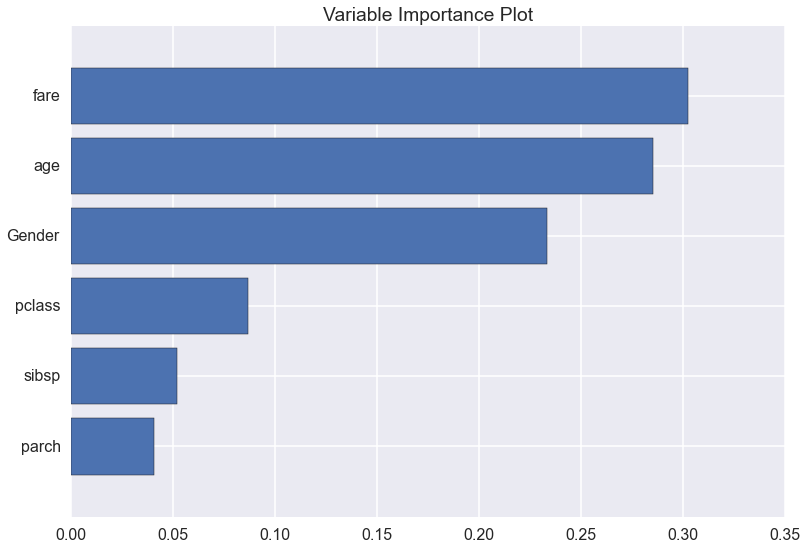

In [63]:
#we get the indices in the order that would make the imporances sorted
sorted_indices = np.argsort(rf_importances)

y_pos = range(len(rf_importances))
plt.barh(y_pos, rf_importances[sorted_indices], align='center')
plt.yticks(y_pos, X_train_df.columns[sorted_indices])
plt.title('Variable Importance Plot')
plt.show()

In [64]:
sorted_indices

array([2, 1, 3, 5, 0, 4], dtype=int64)

In [65]:
#Get accuracy scores on out-of-bag examples
print(rf.oob_score_)
print(rf.oob_decision_function_)

0.783857729138
[[ 0.2907197   0.7092803 ]
 [ 0.98780488  0.01219512]
 [ 0.9844086   0.0155914 ]
 ..., 
 [ 0.95628415  0.04371585]
 [ 0.7431694   0.2568306 ]
 [ 0.92630058  0.07369942]]


In [66]:
#With GridSearchCV(), we can scan over a tuneable parameter in RF to get the best values
param_grid = {"n_estimators" : [1,10,100,500],       #Numb. of trees in the forest
              "max_depth" : [1,2,5, None],           #max depth of a tree
              "max_features" : ['sqrt', 'auto']}     #Numb. of features to consider when looking for best split
cv = GridSearchCV(rf, param_grid, cv = 10, n_jobs = 4, refit = True)
cv.fit(X_train, y_train.ravel())

C:\Users\jberthet001\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=4,
       param_grid={'max_depth': [1, 2, 5, None], 'n_estimators': [1, 10, 100, 500], 'max_features': ['sqrt', 'auto']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [67]:
#Estimator chosen by the GridSearch - or estimator which gave the highest score (or smallest loss) on the test data)
print(cv.best_estimator_)
#Lowest MSE value on test set
print(cv.best_score_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=True, random_state=None, verbose=0, warm_start=False)
0.813953488372


In [68]:
#Most important parameter is number of trees - but here you see. Notice you get mean & variance that aren't the lowest. 
#It chooses best predictor, cuz lowest training likely overfit
cv.grid_scores_

[mean: 0.69904, std: 0.09779, params: {'max_depth': 1, 'n_estimators': 1, 'max_features': 'sqrt'},
 mean: 0.74966, std: 0.05698, params: {'max_depth': 1, 'n_estimators': 10, 'max_features': 'sqrt'},
 mean: 0.74692, std: 0.04706, params: {'max_depth': 1, 'n_estimators': 100, 'max_features': 'sqrt'},
 mean: 0.75650, std: 0.04323, params: {'max_depth': 1, 'n_estimators': 500, 'max_features': 'sqrt'},
 mean: 0.70041, std: 0.08682, params: {'max_depth': 1, 'n_estimators': 1, 'max_features': 'auto'},
 mean: 0.73871, std: 0.04834, params: {'max_depth': 1, 'n_estimators': 10, 'max_features': 'auto'},
 mean: 0.76334, std: 0.04014, params: {'max_depth': 1, 'n_estimators': 100, 'max_features': 'auto'},
 mean: 0.75239, std: 0.04326, params: {'max_depth': 1, 'n_estimators': 500, 'max_features': 'auto'},
 mean: 0.69083, std: 0.06473, params: {'max_depth': 2, 'n_estimators': 1, 'max_features': 'sqrt'},
 mean: 0.77565, std: 0.03215, params: {'max_depth': 2, 'n_estimators': 10, 'max_features': 'sqrt'},

logistic regresiion 0.855936507937
Decision Tree 0.842793650794
Random Forest 0.832825396825
RF_CV 0.864465608466


C:\Users\jberthet001\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


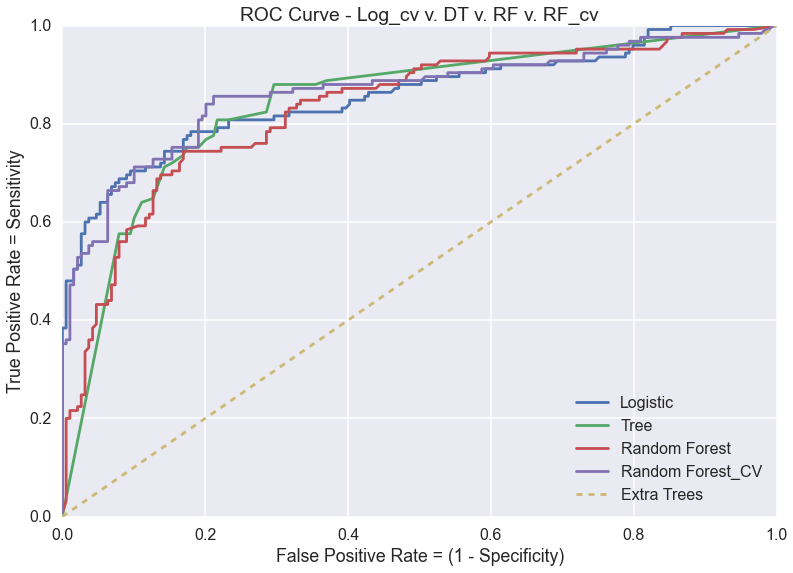

In [69]:
rf_cv = RandomForestClassifier(n_estimators = 500, criterion = 'gini',
                            max_features = 'sqrt', oob_score = True, max_depth = 5,
                            n_jobs = 2, verbose = 0)
rf_cv.fit(X_train, y_train)

rf_cv_test_preds = rf_cv.predict_proba(X_test)[:,1]

fpr_rf_cv, tpr_rf_cv, thresholds_rf_cv = roc_curve(y_test, rf_cv_test_preds)

print ("logistic regresiion %s" % (roc_auc_score(y_test, test_probs_cv)))            
print("Decision Tree %s" % (roc_auc_score(y_test, dt_test_probs)))
print("Random Forest %s" % (roc_auc_score(y_test, rf_test_preds)))
print ("RF_CV %s" % (roc_auc_score(y_test, rf_cv_test_preds)))

plt.plot(fpr, tpr)         #logistic Regression
plt.plot(fpr_dt, tpr_dt)   #decision tree
plt.plot(fpr_rf, tpr_rf)   #random forest
plt.plot(fpr_rf_cv, tpr_rf_cv)   #random forest Cross Validated
plt.plot(fpr_rand, tpr_rand, linestyle = '--')
plt.xlabel('False Positive Rate = (1 - Specificity)')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC Curve - Log_cv v. DT v. RF v. RF_cv')
pl.legend(["Logistic", "Tree", "Random Forest", "Random Forest_CV", "Extra Trees", "Flip a Coin"], loc = 4)

plt.show()

## 8c. Boosting

Gradient Boosting Classifier builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions.

Like rf,
n_estimator : controls # of trees to fit
learning_rate : controls how slowly we want the classifier to learn (smaller value of learning rate the more trees I'll need)

Boosting can often work better than random forest, because trees are grown sequentially, where each tree is grown using information from previously grown trees. Each tree is fit on a modified version of the original data. Boosting learns slowly by fitting a decision tree to the residuals from the model. It slowly improves the algorithm in areas where it does not perform well.

Gradient Boosting is pretty robust to overfitting too!

In [70]:
gbt = GradientBoostingClassifier(learning_rate=0.1,    #shrinkage parameter controls rate of learning
                                 n_estimators=200,     #Number of trees to build
                                 max_depth=3)          #Number of splits within the tree

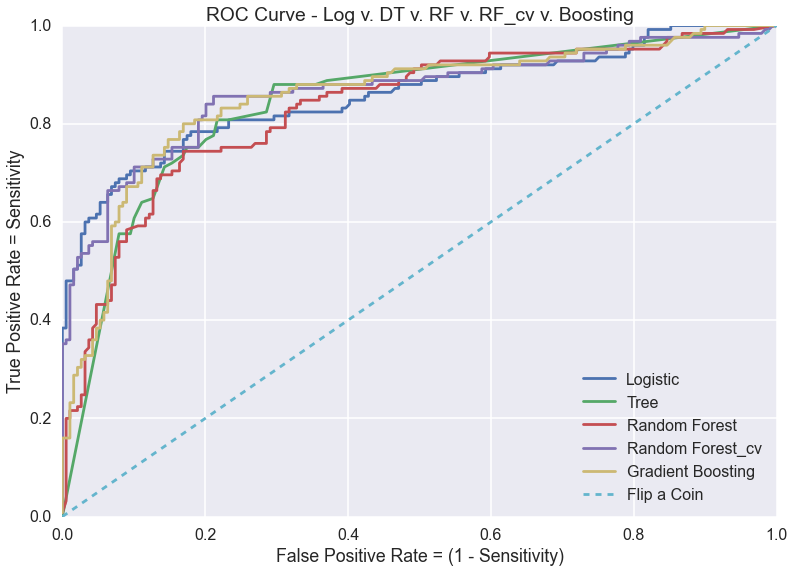

logistic regresiion 0.855936507937
Decision Tree 0.842793650794
Random Forest 0.832825396825
RF_CV 0.864465608466
Boosting 0.855068783069


In [71]:
gbt.fit(X_train, y_train.ravel())

gbt_test_preds = gbt.predict_proba(X_test)[:,1]

fpr_gbt, tpr_gbt, thresholds_gbt = roc_curve(y_test, gbt_test_preds)

plt.plot(fpr, tpr)         #logistic Regression
plt.plot(fpr_dt, tpr_dt)   #decision tree
plt.plot(fpr_rf, tpr_rf)   #random forest
plt.plot(fpr_rf_cv, tpr_rf_cv)   #random forest Cross Validated
plt.plot(fpr_gbt, tpr_gbt) #Gradient Boosting
plt.plot(fpr_rand, tpr_rand, linestyle = '--')
plt.xlabel('False Positive Rate = (1 - Sensitivity)')
plt.ylabel('True Positive Rate = Sensitivity')
plt.title('ROC Curve - Log v. DT v. RF v. RF_cv v. Boosting')
pl.legend(["Logistic", "Tree", "Random Forest", "Random Forest_cv", "Gradient Boosting", "Flip a Coin"], loc = 4)

plt.show()

print ("logistic regresiion %s" % (roc_auc_score(y_test, test_probs_cv)))# print(roc_auc_score(y_bin, bin_preds))       
print("Decision Tree %s" % (roc_auc_score(y_test, dt_test_probs)))
print("Random Forest %s" % (roc_auc_score(y_test, rf_test_preds)))
print ("RF_CV %s" % (roc_auc_score(y_test, rf_cv_test_preds)))
print("Boosting %s" % (roc_auc_score(y_test, gbt_test_preds)))

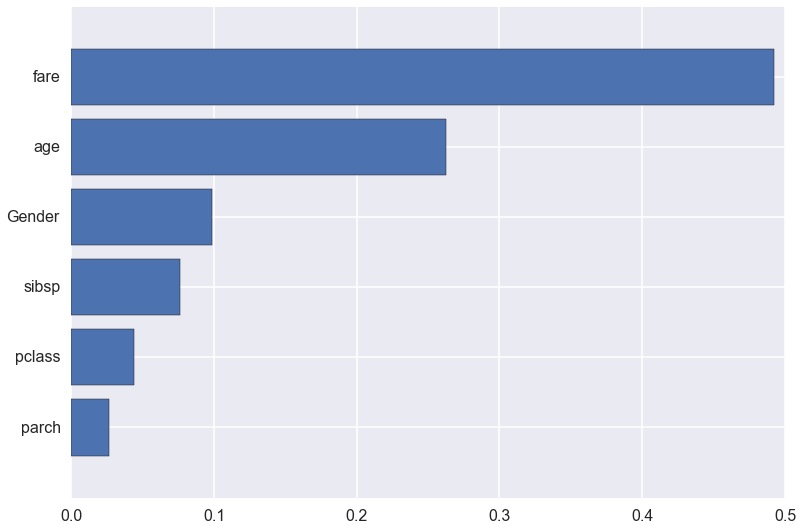

In [72]:
#variable importance
gbt_importances = gbt.feature_importances_
sorted_indices = np.argsort(gbt_importances)

y_pos = range(len(gbt_importances))
plt.barh(y_pos, gbt_importances[sorted_indices], align='center')
plt.yticks(y_pos, X_train_df.columns[sorted_indices])
plt.show()

GBT has a staged_predict fn that shows what the prediction would make after each tree in the ensemble run

In [74]:
num_trees = []
train_errs = []
for i, y_pred in enumerate(gbt.staged_predict(X_train)):
    num_trees.append(i)
    train_errs.append(zero_one_loss(y_train, y_pred))
    
test_errs = []
for i, y_pred in enumerate(gbt.staged_predict(X_test)):
    test_errs.append(zero_one_loss(y_test, y_pred))

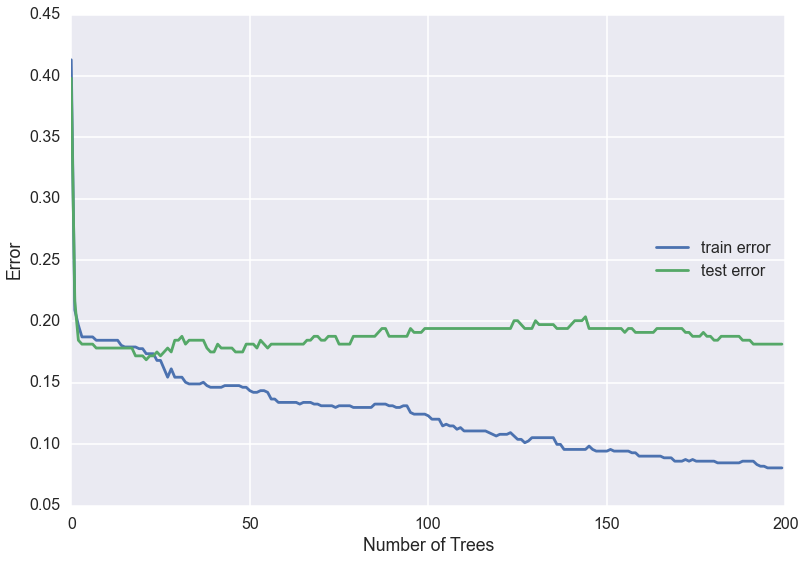

In the graph above, you can see the classic situation where as the model becomes more overfitted, the training error goes down until every point is correctly classified. In contrast, the test error (or prediction accuracy) plateaus / increases slightly as model complexity increases.


In [75]:
plt.plot(num_trees, train_errs)  #blue
plt.plot(num_trees, test_errs)  #green
plt.xlabel("Number of Trees")
plt.ylabel("Error")
pl.legend(["train error", "test error"], loc = 7)
plt.show()

print ("In the graph above, you can see the classic situation where as the model becomes more overfitted, the training error goes down until every point is correctly classified. In contrast, the test error (or prediction accuracy) plateaus / increases slightly as model complexity increases.")
#Good example of changing parameters affects errors

## 8d. Adding Extra Random Trees

Amazingly, just taking random predictors and random split thresholds rather than choosing the best one, does a better job, but here, it does worse. That's what the extra random trees classifer does. It's good to do this cuz it's very fast and I can be lazy about checking which predictors and which values to split on. Just take random ones!

In [76]:
et = ExtraTreesClassifier(n_estimators=500, n_jobs=1)

et.fit(X_train, y_train.ravel())

et_test_preds = et.predict_proba(X_test)[:,1]

fpr_et, tpr_et, thresholds_et = roc_curve(y_test, et_test_preds)

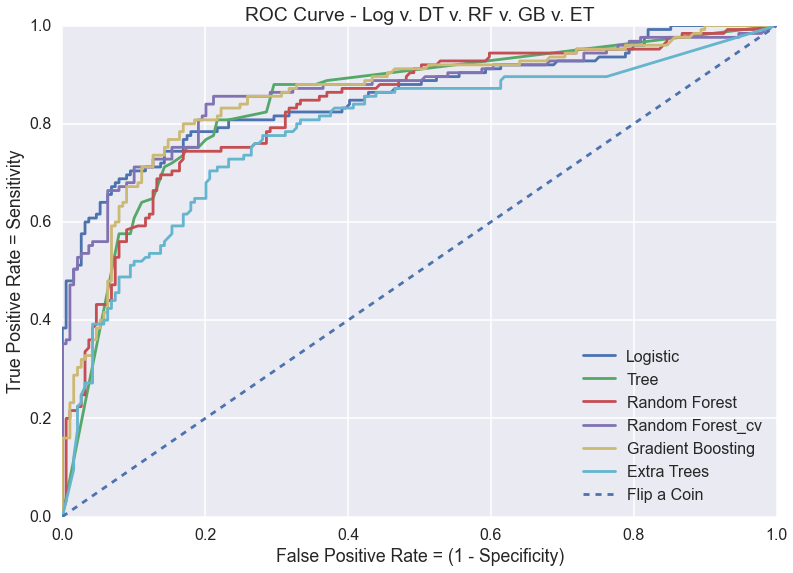

Notice tradeoff of any increase in sensitivity is accompanied by a decrease in specificity
logistic regression 0.855936507937
Decision Tree 0.842793650794
Random Forest 0.832825396825
RF_CV 0.864465608466
Boosting 0.855068783069
Extra Trees 0.787957671958


In [77]:
pl.plot(fpr, tpr)         #logistic Regression
pl.plot(fpr_dt, tpr_dt)   #decision tree
pl.plot(fpr_rf, tpr_rf)   #random forest
plt.plot(fpr_rf_cv, tpr_rf_cv)   #random forest Cross Validated
pl.plot(fpr_gbt, tpr_gbt) #Gradient Boosting
pl.plot(fpr_et, tpr_et)   #Extra Trees
pl.plot(fpr_rand, tpr_rand, linestyle = '--')
pl.xlabel('False Positive Rate = (1 - Specificity)')
pl.ylabel('True Positive Rate = Sensitivity')
pl.title('ROC Curve - Log v. DT v. RF v. GB v. ET')
pl.legend(["Logistic", "Tree", "Random Forest","Random Forest_cv", "Gradient Boosting", "Extra Trees", "Flip a Coin"], loc = 4)
pl.show()

print ("Notice tradeoff of any increase in sensitivity is accompanied by a decrease in specificity")
print ("logistic regression %s" % (roc_auc_score(y_test, test_probs_cv)))
print("Decision Tree %s" % (roc_auc_score(y_test, dt_test_probs)))
print("Random Forest %s" % (roc_auc_score(y_test, rf_test_preds)))
print ("RF_CV %s" % (roc_auc_score(y_test, rf_cv_test_preds)))
print("Boosting %s" % (roc_auc_score(y_test, gbt_test_preds)))
print("Extra Trees %s" % (roc_auc_score(y_test, et_test_preds)))

# IV. Conclusion with Model Comparion & Prediction Results

The Random Forest Model that was searched over a grid of parameters appears to perform the best, but not by much. But I'll still check and see what areas the Random Forest model predicted.

In [78]:
rf_cv_test_pred = rf_cv.predict(X_test)
print(len(rf_cv_test_pred))
print(len(X_test))
print(type(rf_cv_test_pred))
print(type(X_test))
print(rf_cv_test_pred.shape)
print(X_test.shape)

314
314
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(314,)
(314, 6)


In [79]:
#Concatenate Test Results
y_preds_df = pd.DataFrame(rf_cv_test_pred, columns = ['RFPredictedSurvival'])
y_preds_df
FinalResult = pd.concat([X_test_df, y_test_df, y_preds_df], axis=1)
FinalResult

# #Create Column for ggplot
# FinalResult['CorrectPred'] = np.where(FinalResult.loc[:,'survived'] == FinalResult.loc[:,'RFPredictedSurvival'],
#                              'Correct Prediction','Wrong Prediction')

#Survived = Yes
YesSurv = FinalResult.loc[FinalResult['survived'] == 1]
YesSurvGoodPred = YesSurv.loc[YesSurv['RFPredictedSurvival'] == 1]
# YesSurvBadPred = YesSurv.loc[YesSurv['RFPredictedSurvival'] == 0]

#Survived = No
NoSurv = FinalResult.loc[FinalResult['survived'] == 0]
NoSurvGoodPred = NoSurv.loc[NoSurv['RFPredictedSurvival'] == 0]
# NoSurvBadPred = YesSurv.loc[YesSurv['RFPredictedSurvival'] == 1]


Difference between Total And Predicted Correct are the number of incorrect values provided.


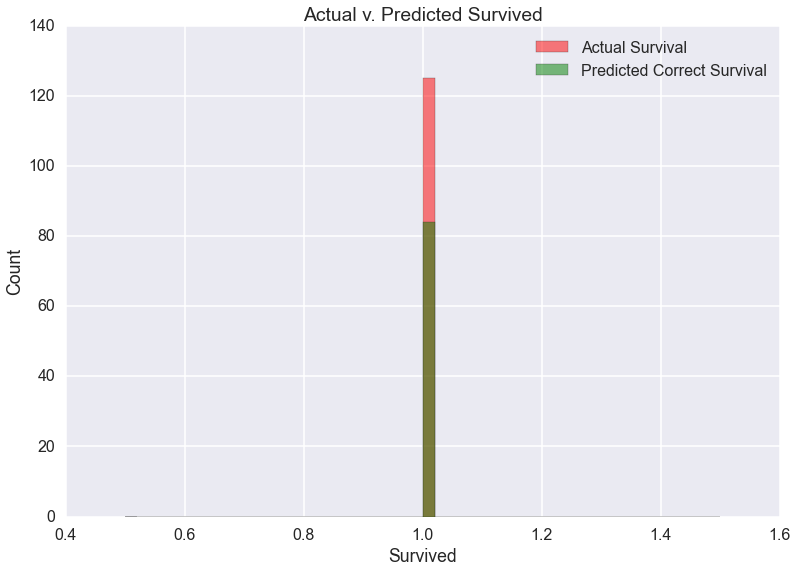

Difference between Total And Predicted Correct are the number of incorrect values provided.


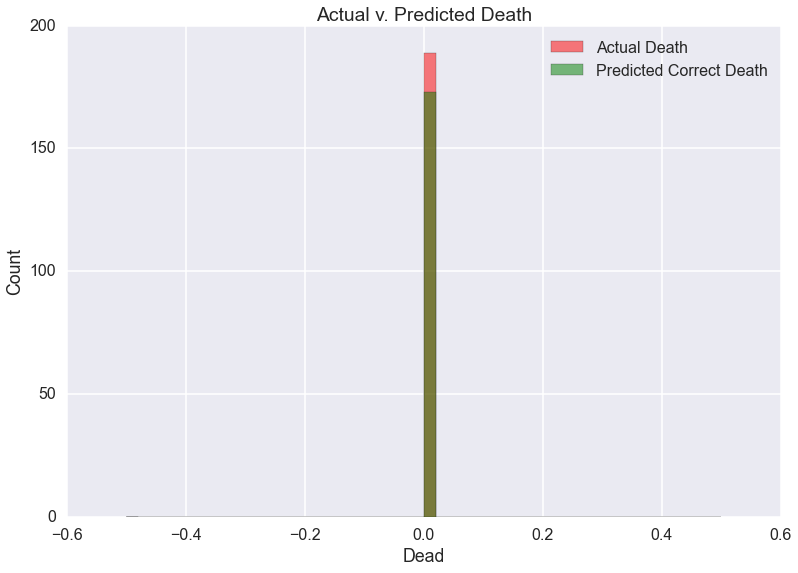

In [80]:
print('Difference between Total And Predicted Correct are the number of incorrect values provided.')
pl.hist(YesSurv.survived.tolist(), bins = 50, alpha = 0.5, color = 'red', label = "Actual Survival")
pl.hist(YesSurvGoodPred.survived.tolist(), bins = 50, color = 'green', alpha = 0.5, label = "Predicted Correct Survival")
pl.legend(loc = 'upper right')
pl.xlabel('Survived')
pl.ylabel('Count')
pl.title('Actual v. Predicted Survived')
pl.show()

print('Difference between Total And Predicted Correct are the number of incorrect values provided.')
pl.hist(NoSurv.survived.tolist(), bins = 50, alpha = 0.5, color = 'red', label = "Actual Death")
pl.hist(NoSurvGoodPred.survived.tolist(), bins = 50, alpha = 0.5, color = 'green', label = "Predicted Correct Death")
pl.legend(loc = 'upper right')
pl.xlabel('Dead')
pl.ylabel('Count')
pl.title('Actual v. Predicted Death')
pl.show()

Difference between Total And Predicted Correct are the number of incorrect values provided.


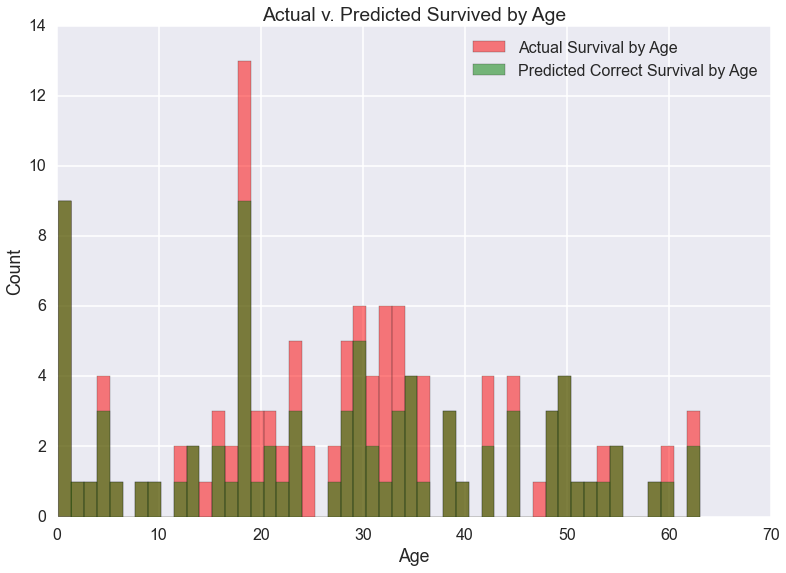

Difference between Total And Predicted Correct are the number of incorrect values provided.


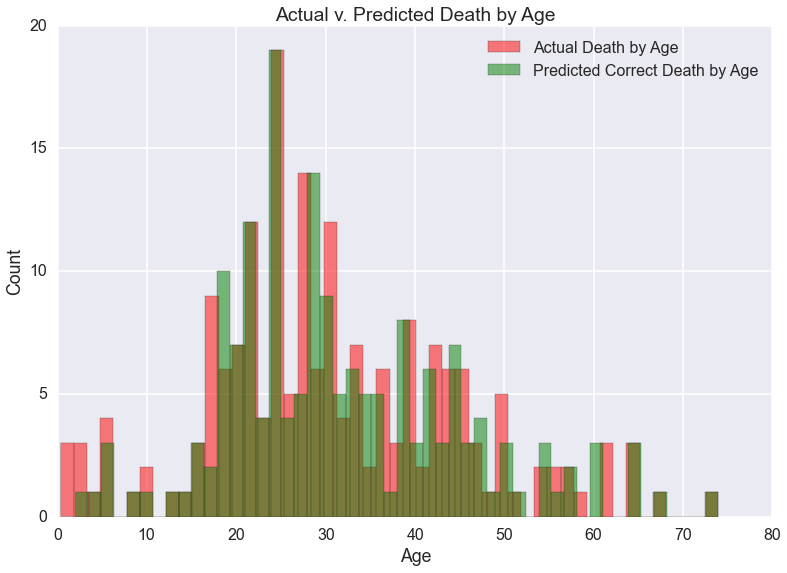

In [81]:
print('Difference between Total And Predicted Correct are the number of incorrect values provided.')
pl.hist(YesSurv.age.tolist(), bins = 50, alpha = 0.5, color = 'red', label = "Actual Survival by Age")
pl.hist(YesSurvGoodPred.age.tolist(), bins = 50, alpha = 0.5, color = 'green',label = "Predicted Correct Survival by Age")
pl.legend(loc = 'upper right')
pl.xlabel('Age')
pl.ylabel('Count')
pl.title('Actual v. Predicted Survived by Age')
pl.show()

print('Difference between Total And Predicted Correct are the number of incorrect values provided.')
pl.hist(NoSurv.age.tolist(), bins = 50, alpha = 0.5, color = 'red', label = "Actual Death by Age")
pl.hist(NoSurvGoodPred.age.tolist(), bins = 50, alpha = 0.5, color = 'green', label = "Predicted Correct Death by Age")

pl.legend(loc = 'upper right')
pl.xlabel('Age')
pl.ylabel('Count')
pl.title('Actual v. Predicted Death by Age')
pl.show()

Difference between Total And Predicted Correct are the number of incorrect values provided.


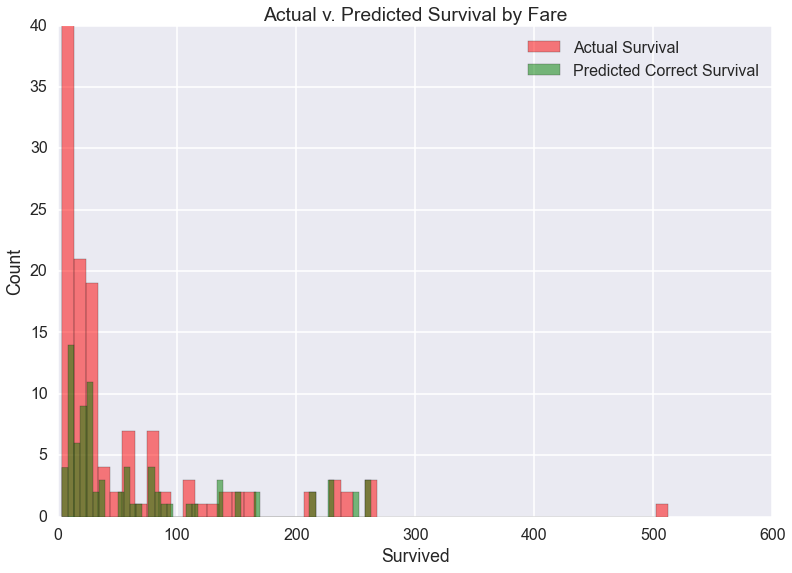

Difference between Total And Predicted Correct are the number of incorrect values provided.


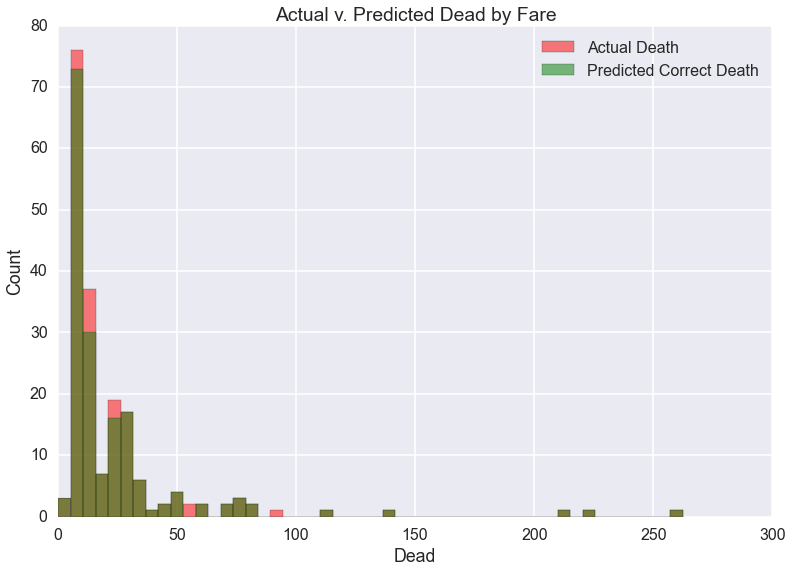

In [82]:
print('Difference between Total And Predicted Correct are the number of incorrect values provided.')
pl.hist(YesSurv.fare.tolist(), bins = 50, alpha = 0.5, color = 'red', label = "Actual Survival")
pl.hist(YesSurvGoodPred.fare.tolist(), bins = 50, color = 'green', alpha = 0.5, label = "Predicted Correct Survival")
pl.legend(loc = 'upper right')
pl.xlabel('Survived')
pl.ylabel('Count')
pl.title('Actual v. Predicted Survival by Fare')
pl.show()

print('Difference between Total And Predicted Correct are the number of incorrect values provided.')
pl.hist(NoSurv.fare.tolist(), bins = 50, alpha = 0.5, color = 'red', label = "Actual Death")
pl.hist(NoSurvGoodPred.fare.tolist(), bins = 50, alpha = 0.5, color = 'green', label = "Predicted Correct Death")
pl.legend(loc = 'upper right')
pl.xlabel('Dead')
pl.ylabel('Count')
pl.title('Actual v. Predicted Dead by Fare')
pl.show()

Difference between Total And Predicted Correct are the number of incorrect values provided.


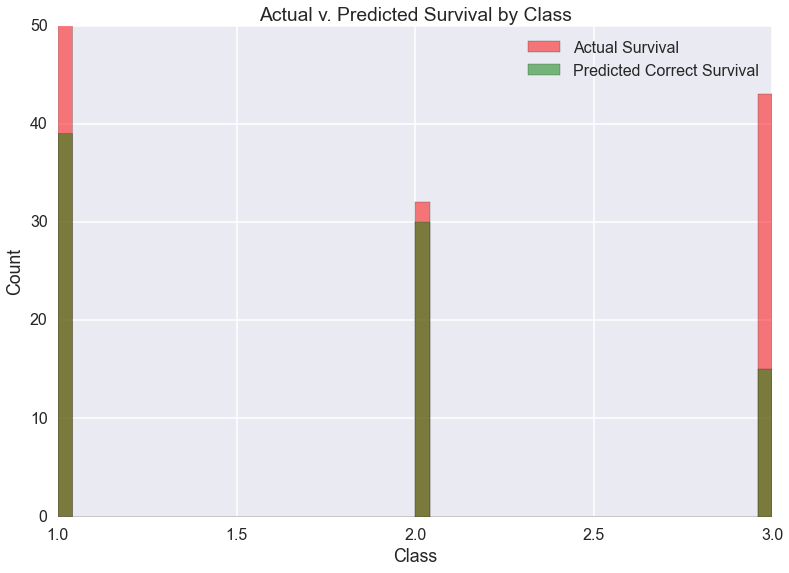

Difference between Total And Predicted Correct are the number of incorrect values provided.


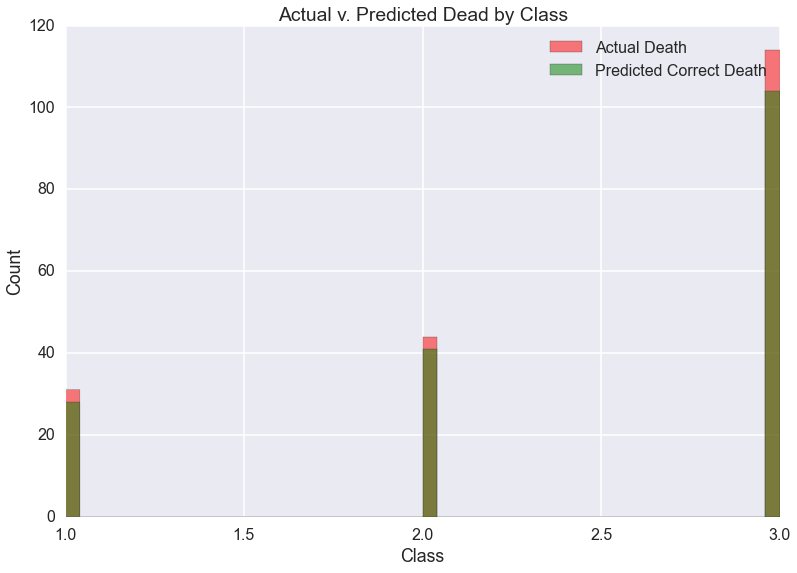

In [83]:
print('Difference between Total And Predicted Correct are the number of incorrect values provided.')
pl.hist(YesSurv.pclass.tolist(), bins = 50, alpha = 0.5, color = 'red', label = "Actual Survival")
pl.hist(YesSurvGoodPred.pclass.tolist(), bins = 50, color = 'green', alpha = 0.5, label = "Predicted Correct Survival")
pl.legend(loc = 'upper right')
pl.xlabel('Class')
pl.ylabel('Count')
pl.title('Actual v. Predicted Survival by Class')
pl.show()

print('Difference between Total And Predicted Correct are the number of incorrect values provided.')
pl.hist(NoSurv.pclass.tolist(), bins = 50, alpha = 0.5, color = 'red', label = "Actual Death")
pl.hist(NoSurvGoodPred.pclass.tolist(), bins = 50, alpha = 0.5, color = 'green', label = "Predicted Correct Death")
pl.legend(loc = 'upper right')
pl.xlabel('Class')
pl.ylabel('Count')
pl.title('Actual v. Predicted Dead by Class')
pl.show()

CONCLUSION : Interestingly, results about my random forest prediction model can be viewed through the comparison of actual vs predicted survived or died. Being cautious of the y-axis values, the random fores tmodel predicts survival and death differently.

For predicting survival by looking at the age variables, it does not predict middle aged people well, but it does well with older and younger people. However, the model seems to predict death a bit better for middle aged people than it does for predicting survival.

In general, the model seemed to predict death better than survival, which may be reflective of there being more data points for the dead than the survived.

The model was quite poor at predicting survival for those who paid small fares and for those in the lower classes. Converseley, the model predicted higher classes and more expensive fare deaths better, especially for the dead more than the survived.